# **CT Scan Image Classification**

**Dataset Information:-**
1. This dataset contains 1252 CT scans that are positive for SARS-CoV-2 infection (COVID-19) and 1230 CT scans for patients non-infected by SARS-CoV-2, 2482 CT scans in total.
2. These data have been collected from real patients in hospitals from Sao Paulo, Brazil.
3. The aim of this dataset is to encourage the research and development of artificial intelligent methods which are able to identify if a person is infected by SARS-CoV-2 through the analysis of his/her CT scans.

## **Importing Libraries**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## **1: Data Preprocessing**

### **1.1 Loading the images**

**Note:-** You need to download data.zip file from this [Link](https://drive.google.com/file/d/1iqtiC9krc44QbLFDH0XsElI5cHoy4P56/view?usp=sharing) into the folder and then run the next cell

In [3]:
# Unzip the data.zip file
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

# Directory containing the extracted data
data_dir = 'data'

covid_dir = os.path.join(data_dir, 'COVID')
non_covid_dir = os.path.join(data_dir, 'non-COVID')

covid_images = []
non_covid_images = []

for filename in os.listdir(covid_dir):
    img_path = os.path.join(covid_dir, filename)
    img = Image.open(img_path)
    covid_images.append(img)

for filename in os.listdir(non_covid_dir):
    img_path = os.path.join(non_covid_dir, filename)
    img = Image.open(img_path)
    non_covid_images.append(img)

### **1.2 Resizing images and Normalizing image data**

In [4]:
# Fixed size of (224, 224) for resizing the images
image_size = (224, 224)

# Converting images to RGB mode and resizing them
covid_images = [img.convert('RGB').resize(image_size) for img in covid_images]
non_covid_images = [img.convert('RGB').resize(image_size) for img in non_covid_images]

# Converting the images to arrays and normalizing the pixel values
covid_data = np.array([img_to_array(img)/255.0 for img in covid_images])
non_covid_data = np.array([img_to_array(img)/255.0 for img in non_covid_images])

# Note:- Here covid_data and non_covid_data now contains the preprocessed and normalized image data.

## **2: Data Augmentation**

In [5]:
# Defining all data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,        # Random rotation (±20 degrees)
    width_shift_range=0.2,    # Random horizontal shift (±20% of image width)
    height_shift_range=0.2,   # Random vertical shift (±20% of image height)
    shear_range=0.2,          # Random shear
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True      # Random horizontal flip
)

# Fitting the data augmentation generator on the data
datagen.fit(covid_data)
datagen.fit(non_covid_data)

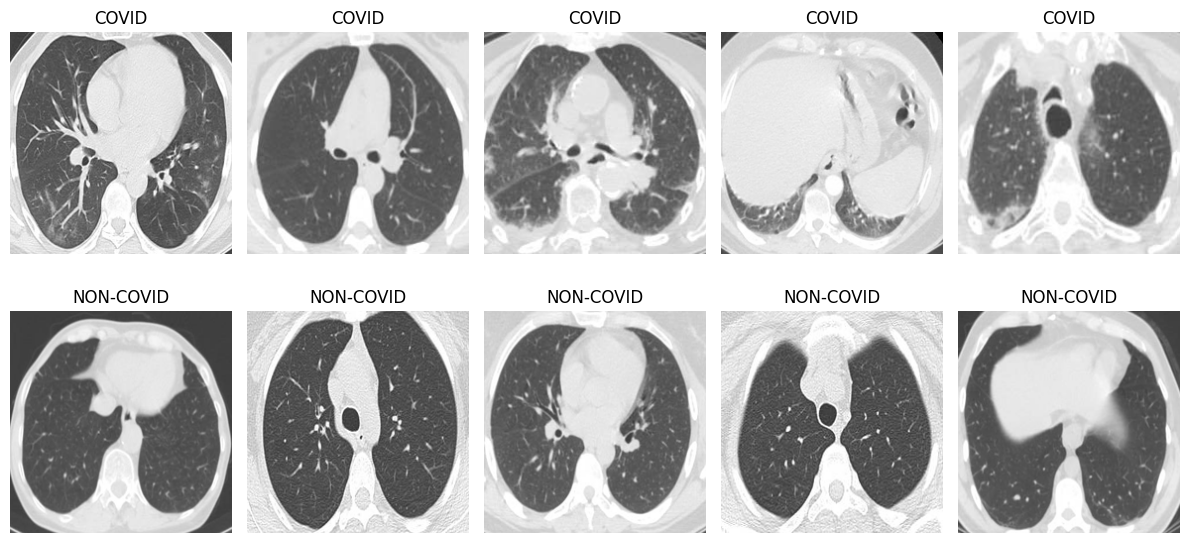

In [6]:
# Display images and count for both Covid and Non Covid class
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(covid_images[i])
    plt.title("COVID")
    plt.axis('off')

for i in range(5):
    plt.subplot(2, 5, i+6)
    plt.imshow(non_covid_images[i])
    plt.title("NON-COVID")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Total images in each class

print("Total COVID images:", len(covid_images))
print("Total NON-COVID images:", len(non_covid_images))

Total COVID images: 1252
Total NON-COVID images: 1229


### **3: Data Generator & Train Test Split**

In [8]:
# Combining COVID and non-COVID data and create labels (0 for non-COVID, 1 for COVID)
X = np.concatenate([non_covid_data, covid_data])
y = np.concatenate([np.zeros(len(non_covid_data)), np.ones(len(covid_data))])

# Spliting data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating data generators for training and validation
train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = datagen.flow(X_val, y_val, batch_size=32)

In [9]:
# Shapes of the training and validation sets
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1984, 224, 224, 3), (497, 224, 224, 3), (1984,), (497,))

## **4. Model Building**

### **4.1 ResNet50 Model Architecture**

In [10]:
# Loading the pre-trained ResNet50 model without the top (classification) layers
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Adding new layers on top of the ResNet50 base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

# Creating the final model with our above specified layers
model = Model(inputs=base_model.input, outputs=output_layer)

# Freezing the base ResNet layers to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 5s 0us/step


In [11]:
# Getting Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## **5: Model Training**

### **5.1: Training the model**

In [12]:
# Define callbacks for early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model using the data generators
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(X_val) // 32,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
62/62 [==============================] - 55s 635ms/step - loss: 0.7156 - accuracy: 0.5076 - val_loss: 0.7025 - val_accuracy: 0.5396
Epoch 2/50
62/62 [==============================] - 36s 576ms/step - loss: 0.6726 - accuracy: 0.5917 - val_loss: 0.6796 - val_accuracy: 0.5708
Epoch 3/50
62/62 [==============================] - 36s 588ms/step - loss: 0.7039 - accuracy: 0.5484 - val_loss: 0.7561 - val_accuracy: 0.4958
Epoch 4/50
62/62 [==============================] - 35s 570ms/step - loss: 0.6790 - accuracy: 0.5670 - val_loss: 0.6675 - val_accuracy: 0.5521
Epoch 5/50
62/62 [==============================] - 34s 542ms/step - loss: 0.6735 - accuracy: 0.5862 - val_loss: 0.6821 - val_accuracy: 0.5771
Epoch 6/50
62/62 [==============================] - 35s 560ms/step - loss: 0.6898 - accuracy: 0.5721 - val_loss: 0.6834 - val_accuracy: 0.5583
Epoch 7/50
62/62 [==============================] - 37s 598ms/step - loss: 0.6651 - accuracy: 0.5796 - val_loss: 0.6551 - val_accuracy: 0.6000

In [13]:
# Loading the best saved model from model checkpoint
best_model = tf.keras.models.load_model('best_model.h5')

# Evaluating the model on the validation set
val_loss, val_accuracy = best_model.evaluate(X_val, y_val, batch_size=32)

print("Validation Loss:", val_loss*100)
print("Validation Accuracy:", val_accuracy*100)


# Evaluate the model on the training set
train_loss, train_accuracy = best_model.evaluate(X_train, y_train, batch_size=32)

print("train Loss:", train_loss*100)
print("train Accuracy:", train_accuracy*100)

16/16 [==============================] - 3s 155ms/step - loss: 0.6260 - accuracy: 0.6600
Validation Loss: 62.597137689590454
Validation Accuracy: 65.99597334861755
62/62 [==============================] - 6s 100ms/step - loss: 0.6200 - accuracy: 0.6562
train Loss: 61.99883222579956
train Accuracy: 65.625


## **6: Model Evaluation and Prediction**

### **6.1 Model Evaluation:**

In [14]:
# Load the best saved model
best_model = tf.keras.models.load_model('best_model.h5')

# Evaluate the model on the test set
y_pred = best_model.predict(X_val)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate performance metrics
accuracy = accuracy_score(y_val, y_pred_binary)
precision = precision_score(y_val, y_pred_binary)
recall = recall_score(y_val, y_pred_binary)
f1 = f1_score(y_val, y_pred_binary)
conf_matrix = confusion_matrix(y_val, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

16/16 [==============================] - 3s 100ms/step
Accuracy: 0.6599597585513078
Precision: 0.6859504132231405
Recall: 0.640926640926641
F1 Score: 0.6626746506986028
Confusion Matrix:
 [[162  76]
 [ 93 166]]


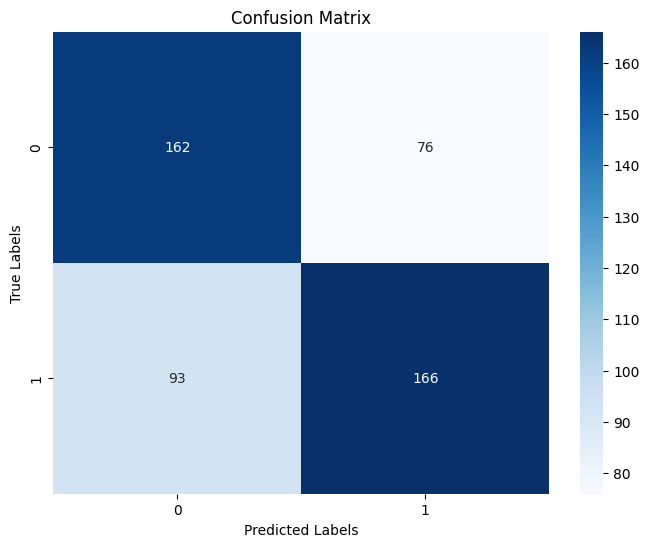

In [15]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **7. Fine Tuning our Best Model**

In [16]:
# Unfreezing last 20 layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compiling the model again after unfreezing layers
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with fine-tuning
fine_tune_epochs = 60
history_fine = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=fine_tune_epochs,
    validation_data=datagen.flow(X_val, y_val, batch_size=32),
    validation_steps=len(X_val) // 32,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate and predict as before
best_fine_tuned_model = load_model('best_model.h5')

y_pred_fine = best_fine_tuned_model.predict(X_val)
y_pred_binary_fine = (y_pred_fine > 0.5).astype(int)

accuracy_fine = accuracy_score(y_val, y_pred_binary_fine)
precision_fine = precision_score(y_val, y_pred_binary_fine)
recall_fine = recall_score(y_val, y_pred_binary_fine)
f1_fine = f1_score(y_val, y_pred_binary_fine)
conf_matrix_fine = confusion_matrix(y_val, y_pred_binary_fine)

print("Accuracy (Fine-Tuned):", accuracy_fine*100)
print("Precision (Fine-Tuned):", precision_fine*100)
print("Recall (Fine-Tuned):", recall_fine)
print("F1 Score (Fine-Tuned):", f1_fine)
print("Confusion Matrix (Fine-Tuned):\n", conf_matrix_fine)


Epoch 1/60
62/62 [==============================] - 46s 593ms/step - loss: 0.7210 - accuracy: 0.5504 - val_loss: 0.6981 - val_accuracy: 0.5229
Epoch 2/60
62/62 [==============================] - 32s 518ms/step - loss: 0.6591 - accuracy: 0.5958 - val_loss: 0.6940 - val_accuracy: 0.5292
Epoch 3/60
62/62 [==============================] - 31s 501ms/step - loss: 0.6346 - accuracy: 0.6416 - val_loss: 0.6510 - val_accuracy: 0.6229
Epoch 4/60
62/62 [==============================] - 35s 558ms/step - loss: 0.6044 - accuracy: 0.6598 - val_loss: 1.1957 - val_accuracy: 0.5583
Epoch 5/60
62/62 [==============================] - 35s 567ms/step - loss: 0.5876 - accuracy: 0.6714 - val_loss: 2.2157 - val_accuracy: 0.4812
Epoch 6/60
62/62 [==============================] - 32s 510ms/step - loss: 0.5567 - accuracy: 0.7067 - val_loss: 1.3337 - val_accuracy: 0.5417
Epoch 7/60
62/62 [==============================] - 36s 579ms/step - loss: 0.5758 - accuracy: 0.7016 - val_loss: 0.5987 - val_accuracy: 0.7000

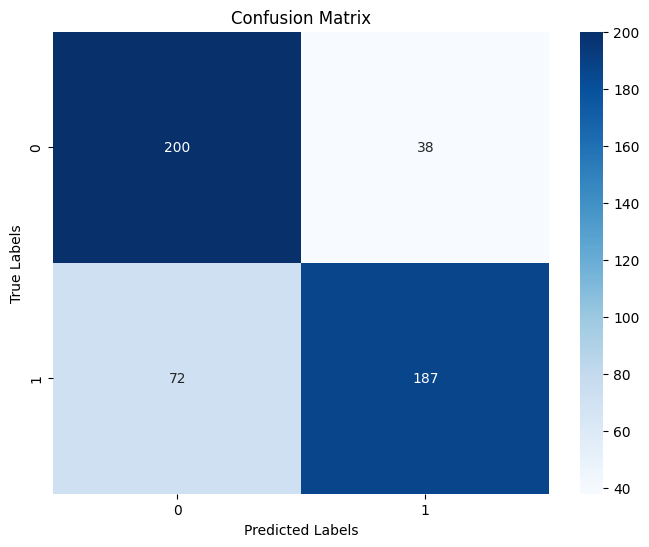

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_fine, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# Unfreezing last 40 layers for fine-tuning
for layer in base_model.layers[-40:]:
    layer.trainable = True

# Compiling the model again after unfreezing layers
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model with fine-tuning
fine_tune_epochs = 80
history_fine = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=fine_tune_epochs,
    validation_data=datagen.flow(X_val, y_val, batch_size=32),
    validation_steps=len(X_val) // 32,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate and predict as before
best_fine_tuned_model = load_model('best_model.h5')

y_pred_fine = best_fine_tuned_model.predict(X_val)
y_pred_binary_fine = (y_pred_fine > 0.5).astype(int)

accuracy_fine = accuracy_score(y_val, y_pred_binary_fine)
precision_fine = precision_score(y_val, y_pred_binary_fine)
recall_fine = recall_score(y_val, y_pred_binary_fine)
f1_fine = f1_score(y_val, y_pred_binary_fine)
conf_matrix_fine = confusion_matrix(y_val, y_pred_binary_fine)

print("Accuracy (Fine-Tuned):", accuracy_fine*100)
print("Precision (Fine-Tuned):", precision_fine*100)
print("Recall (Fine-Tuned):", recall_fine)
print("F1 Score (Fine-Tuned):", f1_fine)
print("Confusion Matrix (Fine-Tuned):\n", conf_matrix_fine)


Epoch 1/80
62/62 [==============================] - 49s 592ms/step - loss: 0.6594 - accuracy: 0.6104 - val_loss: 18.8418 - val_accuracy: 0.4812
Epoch 2/80
62/62 [==============================] - 36s 584ms/step - loss: 0.6226 - accuracy: 0.6547 - val_loss: 7.1871 - val_accuracy: 0.4854
Epoch 3/80
62/62 [==============================] - 36s 581ms/step - loss: 0.5950 - accuracy: 0.6835 - val_loss: 22.6098 - val_accuracy: 0.4792
Epoch 4/80
62/62 [==============================] - 33s 528ms/step - loss: 0.5677 - accuracy: 0.7137 - val_loss: 11.9012 - val_accuracy: 0.5250
Epoch 5/80
62/62 [==============================] - 36s 585ms/step - loss: 0.5583 - accuracy: 0.7082 - val_loss: 3.4402 - val_accuracy: 0.5312
Epoch 6/80
62/62 [==============================] - 36s 584ms/step - loss: 0.5250 - accuracy: 0.7429 - val_loss: 16.0659 - val_accuracy: 0.4729
Epoch 7/80
62/62 [==============================] - 38s 607ms/step - loss: 0.5450 - accuracy: 0.7198 - val_loss: 8.2294 - val_accuracy: 0.

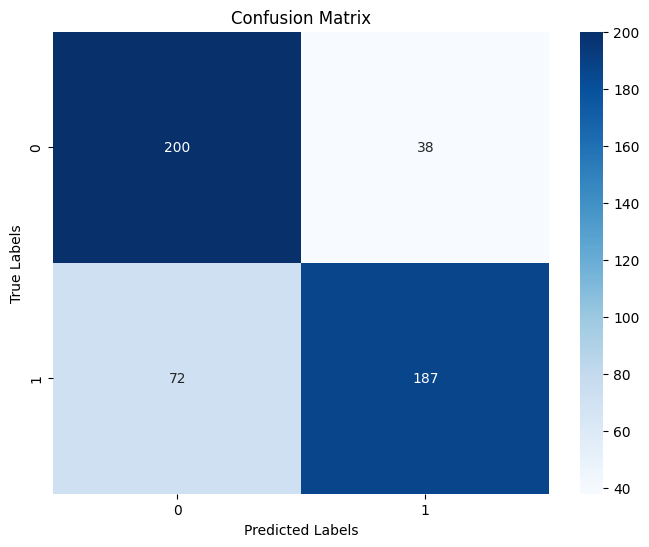

In [19]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_fine, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### **Observations**
* After training our ResNet50 model with additional layers like Pooling layers and Dense layers we got an accuracy of **65.99%**
* After fine tuning our Best Model, we received an accuracy of **77.86%.**

In [20]:
def predict_ct_scan_class(test_image_path, model_path='best_model.h5'):
    # Loading the test image
    test_image = Image.open(test_image_path)

    # Performing preprocessing on image
    if test_image.mode == 'RGBA':
        test_image = test_image.convert('RGB')

    # Resize and normalize the test image
    image_size = (224, 224)
    test_image = test_image.resize(image_size)
    test_image_array = np.array(test_image) / 255.0
    test_image_array = np.expand_dims(test_image_array, axis=0)

    # Loading the trained model
    best_model = load_model(model_path)

    # Making the prediction
    prediction = best_model.predict(test_image_array)
    predicted_class = "COVID" if prediction[0][0] > 0.5 else "NON-COVID"

    return predicted_class

In [21]:
test_image_path = 'img1.png'
predicted_class = predict_ct_scan_class(test_image_path)

print("Predicted class:", predicted_class)

1/1 [==============================] - 2s 2s/step
Predicted class: COVID
